In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Cài đặt các thư viện cần thiết
!pip install rasterio
!pip install earthpy
!pip install scikit-learn
!pip install tensorflow

# Import các thư viện
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import earthpy.plot as ep
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from matplotlib.colors import ListedColormap, BoundaryNorm
import tensorflow as tf

# Kiểm tra GPU
print("GPU:", tf.config.list_physical_devices('GPU'))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.1 MB/s eta 0:00:00a 0:00:01


In [3]:
# Đường dẫn tới file dữ liệu mẫu
SAMPLE_PATH = '/kaggle/input/dataupdatebarrenland/dataDaUpdateBarren.csv'

# Đọc dữ liệu mẫu
samples = pd.read_csv(SAMPLE_PATH)

# Hiển thị một vài dòng dữ liệu
print("Sample data:")
print(samples.head())


Sample data:
              label        Long        Lat      B1      B2      B3      B4  \
0  residential land  105.350638  19.842292  0.1286  0.1168  0.1105  0.1008   
1  residential land  105.350667  19.842251  0.1286  0.1149  0.1113  0.0961   
2  residential land  105.350709  19.842307  0.1286  0.1295  0.1161  0.1087   
3  residential land  105.350594  19.842246  0.1286  0.1153  0.1131  0.1016   
4  residential land  105.351503  19.842991  0.1315  0.1176  0.1116  0.1029   

       B5      B6      B7  ...     B8A      B9     B10     B11     B12  \
0  0.1159  0.2020  0.2458  ...  0.2778  0.0399  0.0009  0.2187  0.1360   
1  0.1103  0.2280  0.2827  ...  0.3162  0.0399  0.0009  0.1820  0.0970   
2  0.1194  0.2288  0.2561  ...  0.2983  0.0399  0.0009  0.2117  0.1534   
3  0.1209  0.2279  0.2774  ...  0.3124  0.0399  0.0009  0.2090  0.1255   
4  0.1173  0.1889  0.2379  ...  0.2512  0.0418  0.0009  0.2125  0.1680   

       NDVI      NDWI      NDBI      NDMI       BSI  
0  0.345029 -0.3039

In [4]:
# Danh sách các đặc trưng (loại bỏ 'B1', 'Long', 'Lat')
FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
            'B9', 'B10', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI', 'NDMI', 'BSI']

# Loại bỏ cột 'B1', 'Long', và 'Lat' khỏi DataFrame
samples = samples.drop(columns=['B1', 'Long', 'Lat'])
LABEL = 'label'

In [5]:
# Khởi tạo LabelEncoder
le = LabelEncoder()

# Áp dụng LabelEncoder cho cột 'label'
samples['label_encoded'] = le.fit_transform(samples[LABEL])

# Lưu lại mapping giữa nhãn và số
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping giữa nhãn và số:", label_mapping)

# Số lượng lớp
N_CLASSES = len(label_mapping)

# Tính toán class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(samples['label_encoded']),
    y=samples['label_encoded']
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Mapping giữa nhãn và số: {'barren land': 0, 'cropland': 1, 'forest': 2, 'open water': 3, 'residential land': 4, 'rice paddy': 5}
Class weights: {0: 0.6677132166358436, 1: 1.4785714285714286, 2: 0.7644017725258493, 3: 1.034862018397547, 4: 1.1596205557215418, 5: 1.4510701934760257}


In [6]:
# Chia dữ liệu thành tập train và test
train, test = train_test_split(samples, test_size=0.2, random_state=42, stratify=samples['label_encoded'])

# Hiển thị số lượng mẫu trong mỗi tập
print(f"Số lượng mẫu trong tập train: {len(train)}")
print(f"Số lượng mẫu trong tập test: {len(test)}")


Số lượng mẫu trong tập train: 74520
Số lượng mẫu trong tập test: 18630


In [7]:
# Chuẩn bị dữ liệu cho chuẩn hóa
scaler = StandardScaler()

# Áp dụng scaler cho các đặc trưng
train_features = scaler.fit_transform(train[FEATURES])
test_features = scaler.transform(test[FEATURES])


In [8]:
# Chuyển đổi nhãn thành one-hot encoding
train_labels = to_categorical(train['label_encoded'], N_CLASSES)
test_labels = to_categorical(test['label_encoded'], N_CLASSES)


In [9]:
# Reshape dữ liệu cho CNN
def reshape_input(array):
    return array.reshape(array.shape[0], array.shape[1], 1)

train_input = reshape_input(train_features)
test_input = reshape_input(test_features)

# Hiển thị kích thước dữ liệu
print(f'Train features: {train_input.shape}')
print(f'Test features: {test_input.shape}')
print(f'Train labels: {train_labels.shape}')
print(f'Test labels: {test_labels.shape}')


Train features: (74520, 17, 1)
Test features: (18630, 17, 1)
Train labels: (74520, 6)
Test labels: (18630, 6)


In [12]:
from tensorflow.keras.layers import GlobalAveragePooling1D


In [13]:
# Định nghĩa input_shape
input_shape = (train_input.shape[1], train_input.shape[2])


model = Sequential([
    Input(shape=input_shape),
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    GlobalAveragePooling1D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(N_CLASSES, activation='softmax')
])

# Hiển thị tóm tắt mô hình
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 17, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 17, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 17, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 17, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 8, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 8, 256)         │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 714,630 (2.73 MB)

 Trainable params: 712,070 (2.72 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [16]:
# Khởi tạo optimizer
optimizer = Adam(learning_rate=1e-2)

# Sử dụng focal loss (tuỳ chọn)
# from tensorflow.keras.losses import CategoricalCrossentropy
# loss_fn = CategoricalCrossentropy()
# Hoặc bạn có thể sử dụng focal loss bằng cách cài đặt thêm thư viện

# Biên dịch mô hình
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Định nghĩa các callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Huấn luyện mô hình
history = model.fit(
    x=train_input,
    y=train_labels,
    validation_data=(test_input, test_labels),
    epochs=50,
    batch_size=2048,  # Sử dụng batch size lớn để tận dụng GPU P100
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.6297 - loss: 1.8289 - val_accuracy: 0.4841 - val_loss: 6.0190 - learning_rate: 0.0100
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7933 - loss: 0.5935 - val_accuracy: 0.3561 - val_loss: 6.1756 - learning_rate: 0.0100
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8183 - loss: 0.5147 - val_accuracy: 0.2807 - val_loss: 6.6729 - learning_rate: 0.0100
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8365 - loss: 0.4676 - val_accuracy: 0.2648 - val_loss: 6.0302 - learning_rate: 0.0050
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8518 - loss: 0.4300 - val_accuracy: 0.2364 - val_loss: 6.6925 - learning_rate: 0.0050
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8575 - loss: 0.4102 - val_accuracy: 0.2725 - val_loss: 5.1241 - learning_rate: 0.0025
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8630 - loss: 0.3933 - val_a

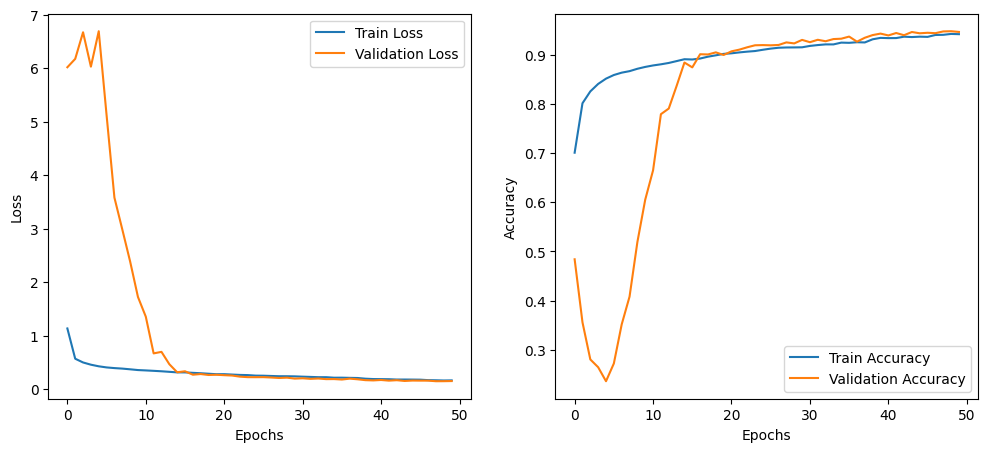

In [17]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(12, 5))

# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


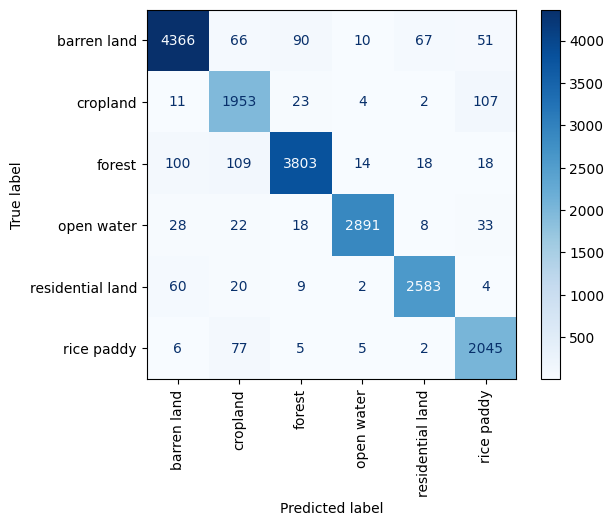

In [18]:
# Dự đoán trên tập test
test_predictions = model.predict(test_input)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

# Ma trận nhầm lẫn
cm = confusion_matrix(test_true_labels, test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


In [19]:
# Báo cáo phân loại
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=le.classes_))


Classification Report:
                  precision    recall  f1-score   support

     barren land       0.96      0.94      0.95      4650
        cropland       0.87      0.93      0.90      2100
          forest       0.96      0.94      0.95      4062
      open water       0.99      0.96      0.98      3000
residential land       0.96      0.96      0.96      2678
      rice paddy       0.91      0.96      0.93      2140

        accuracy                           0.95     18630
       macro avg       0.94      0.95      0.94     18630
    weighted avg       0.95      0.95      0.95     18630



In [20]:
# Import các thư viện cần thiết
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Thêm dòng này
from matplotlib.colors import ListedColormap, BoundaryNorm

# Phần còn lại của code...


In [21]:
# Đường dẫn tới file ảnh vệ tinh
IMAGE_PATH = '/kaggle/input/predict-image/hehee.tif'

# Đọc ảnh vệ tinh
image = rasterio.open(IMAGE_PATH)

# Lấy thông tin ảnh
height = image.height
width = image.width
band_count = image.count

print(f'Image dimensions: {width} x {height}')
print(f'Number of bands: {band_count}')


Image dimensions: 474 x 308
Number of bands: 13


In [22]:
# Tạo dictionary cho các band (loại bỏ B1)
band_indices = {
    'B2': 2, 'B3': 3, 'B4': 4, 'B5': 5, 'B6': 6, 'B7': 7, 'B8': 8,
    'B8A': 9, 'B9': 10, 'B10': 11, 'B11': 12, 'B12': 13
}

# Đọc các band cần thiết và tính toán các chỉ số
bands_data = {}
for feature in FEATURES:
    if feature in band_indices:
        # Đọc band từ ảnh
        band_data = image.read(band_indices[feature]).astype('float32')
        bands_data[feature] = band_data.flatten()
    elif feature == 'NDVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
        bands_data[feature] = ndvi
    elif feature == 'NDWI':
        B3 = image.read(band_indices['B3']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
        bands_data[feature] = ndwi
    elif feature == 'NDBI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndbi = (B11 - B8) / (B11 + B8 + 1e-6)
        bands_data[feature] = ndbi
    elif feature == 'NDMI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        ndmi = (B8 - B11) / (B8 + B11 + 1e-6)
        bands_data[feature] = ndmi
    elif feature == 'BSI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B2 = image.read(band_indices['B2']).astype('float32').flatten()
        bsi = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2) + 1e-6)
        bands_data[feature] = bsi
    else:
        print(f"Chỉ số {feature} chưa được tính toán.")


In [23]:
# Tạo DataFrame cho image_input_data với tên cột
image_input_df = pd.DataFrame(bands_data, columns=FEATURES)

# Áp dụng scaler đã fit trên tập train
image_input_scaled = scaler.transform(image_input_df)


In [24]:
# Reshape dữ liệu
image_input = reshape_input(image_input_scaled)


In [25]:
# Dự đoán
batch_size = 8192  # Chọn batch size phù hợp với bộ nhớ GPU
image_predictions = model.predict(image_input, batch_size=batch_size)
image_pred_labels = np.argmax(image_predictions, axis=1)

# Reshape lại thành kích thước ảnh gốc
prediction_image = image_pred_labels.reshape((height, width))


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step


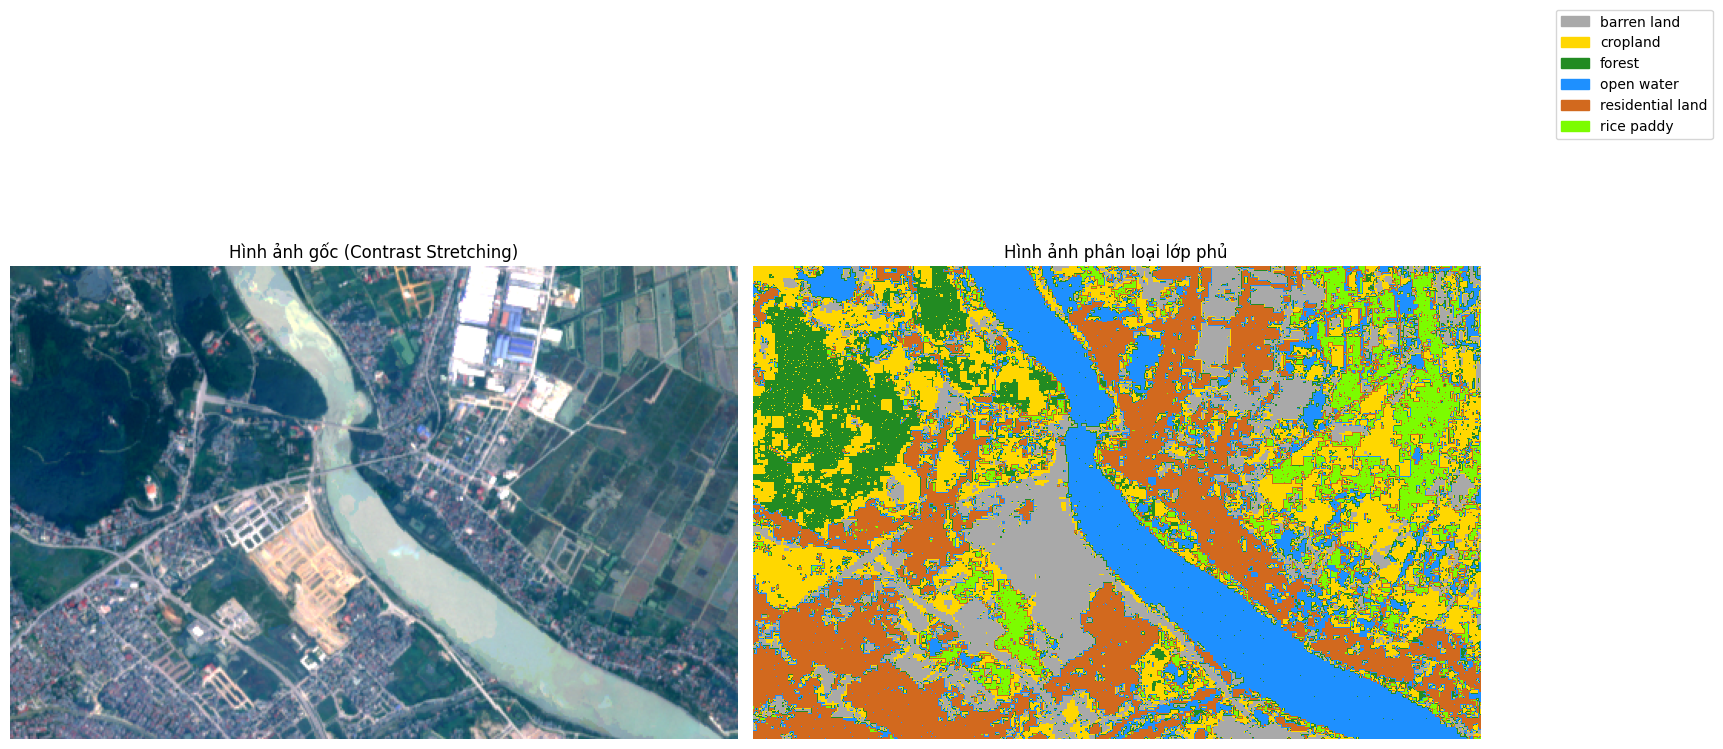

In [29]:
from skimage import exposure # Thêm thư viện skimage
# Tạo bảng màu cho các lớp
PALETTE = ['#A9A9A9',  # barren land - dark gray
           '#FFD700',  # cropland - gold
           '#228B22',  # forest - forest green
           '#1E90FF',  # open water - dodger blue
           '#D2691E',  # residential land - chocolate
           '#7CFC00']  # rice paddy - lawn green

# Colormap và norm cho ảnh phân loại
cmap = ListedColormap(PALETTE)
norm = BoundaryNorm(range(N_CLASSES+1), cmap.N)

# Tạo danh sách tên lớp theo thứ tự
class_names = [None] * N_CLASSES
for label, index in label_mapping.items():
    class_names[index] = label

# Đọc các band RGB (thường là B4, B3, B2)
band_red = image.read(band_indices['B4'])
band_green = image.read(band_indices['B3'])
band_blue = image.read(band_indices['B2'])

# Kết hợp các band lại thành hình ảnh RGB
rgb_image = np.dstack((band_red, band_green, band_blue))

# --- ÁP DỤNG CÁC PHƯƠNG PHÁP LÀM SÁNG ---

p2, p98 = np.percentile(rgb_image, (2, 98))
rgb_image_contrast = exposure.rescale_intensity(rgb_image, in_range=(p2, p98))

# Tạo figure với 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Hiển thị ảnh gốc sau khi áp dụng Contrast Stretching
axes[0].imshow(rgb_image_contrast) # Thay rgb_image bằng rgb_image_contrast
axes[0].set_title("Hình ảnh gốc (Contrast Stretching)") # Thay đổi title cho phù hợp
axes[0].axis('off')

# Hiển thị ảnh phân loại
im = axes[1].imshow(prediction_image, cmap=cmap, norm=norm)
axes[1].set_title("Hình ảnh phân loại lớp phủ")
axes[1].axis('off')

# Tạo chú thích (legend)
patches = [mpatches.Patch(color=PALETTE[i], label=class_names[i]) for i in range(N_CLASSES)]
fig.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

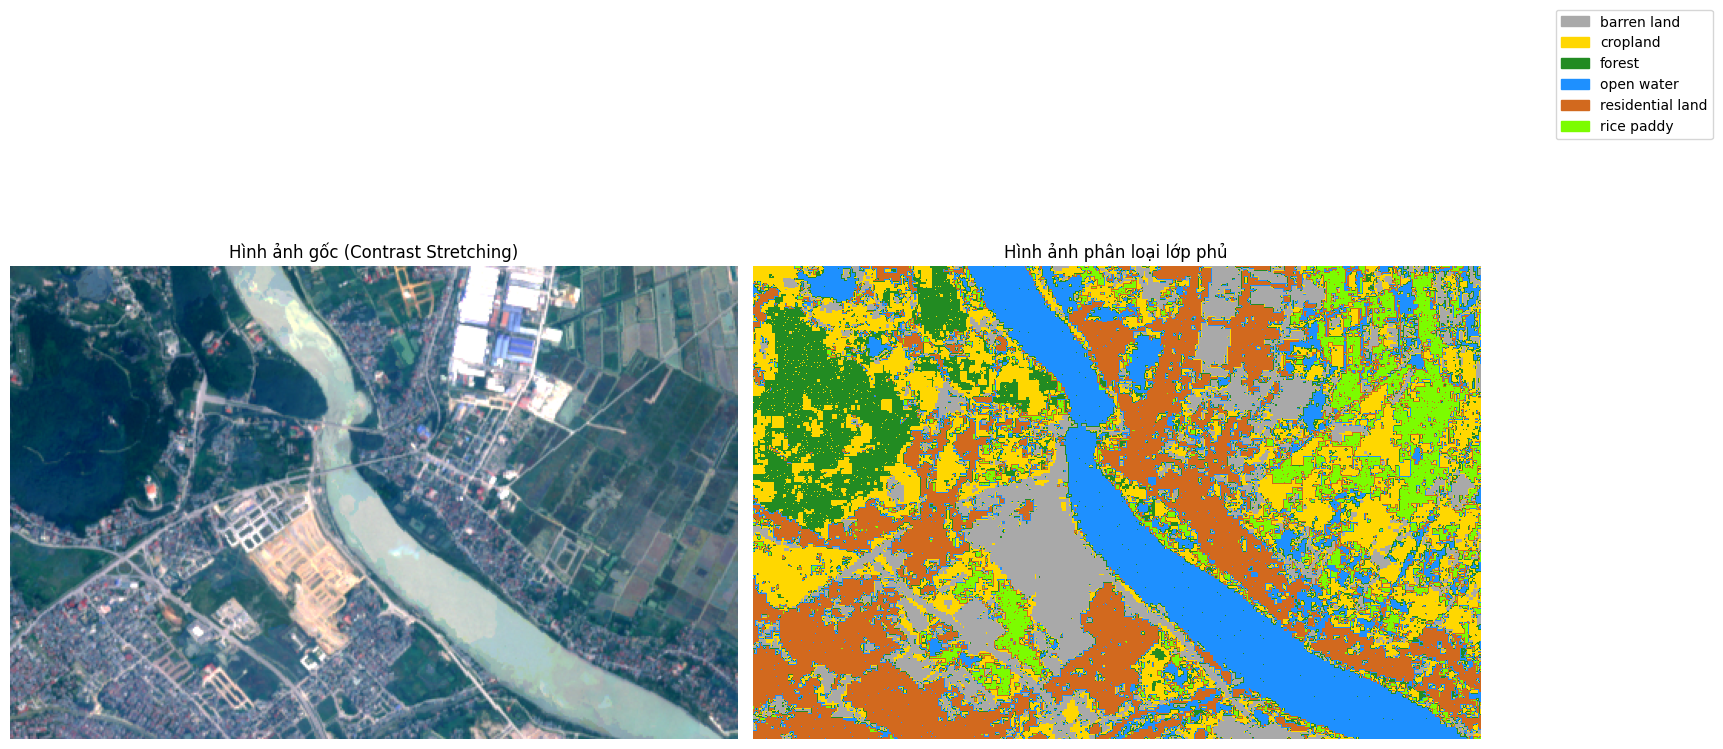

In [28]:
p2, p98 = np.percentile(rgb_image, (2, 98))
rgb_image_contrast = exposure.rescale_intensity(rgb_image, in_range=(p2, p98))

# Tạo figure với 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Hiển thị ảnh gốc sau khi áp dụng Contrast Stretching
axes[0].imshow(rgb_image_contrast) # Thay rgb_image bằng rgb_image_contrast
axes[0].set_title("Hình ảnh gốc (Contrast Stretching)") # Thay đổi title cho phù hợp
axes[0].axis('off')

# Hiển thị ảnh phân loại
im = axes[1].imshow(prediction_image, cmap=cmap, norm=norm)
axes[1].set_title("Hình ảnh phân loại lớp phủ")
axes[1].axis('off')

# Tạo chú thích (legend)
patches = [mpatches.Patch(color=PALETTE[i], label=class_names[i]) for i in range(N_CLASSES)]
fig.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

**HÌNH ẢNH XGBOOST DỰ ĐOÁN KÉM NHẤT**

In [30]:
# Đường dẫn tới file ảnh vệ tinh
IMAGE_PATH = '/kaggle/input/hinhanhxgboostkem/laymau_image.tif'

# Đọc ảnh vệ tinh
image = rasterio.open(IMAGE_PATH)

# Lấy thông tin ảnh
height = image.height
width = image.width
band_count = image.count

print(f'Image dimensions: {width} x {height}')
print(f'Number of bands: {band_count}')


Image dimensions: 225 x 127
Number of bands: 26


In [35]:
# Tạo dictionary cho các band (loại bỏ B1)
band_indices = {
    'B2': 1, 'B3': 2, 'B4': 3, 'B5': 4, 'B6': 5, 'B7': 6, 'B8': 7,
    'B8A': 8, 'B9': 9, 'B10': 10, 'B11': 11, 'B12': 12
}

# Đọc các band cần thiết và tính toán các chỉ số
bands_data = {}
for feature in FEATURES:
    if feature in band_indices:
        # Đọc band từ ảnh
        band_data = image.read(band_indices[feature]).astype('float32')
        bands_data[feature] = band_data.flatten()
    elif feature == 'NDVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        ndvi = (B8 - B4) / (B8 + B4 + 1e-6)
        bands_data[feature] = ndvi
    elif feature == 'NDWI':
        B3 = image.read(band_indices['B3']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
        bands_data[feature] = ndwi
    elif feature == 'NDBI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndbi = (B11 - B8) / (B11 + B8 + 1e-6)
        bands_data[feature] = ndbi
    elif feature == 'NDMI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        ndmi = (B8 - B11) / (B8 + B11 + 1e-6)
        bands_data[feature] = ndmi
    elif feature == 'BSI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B2 = image.read(band_indices['B2']).astype('float32').flatten()
        bsi = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2) + 1e-6)
        bands_data[feature] = bsi
    else:
        print(f"Chỉ số {feature} chưa được tính toán.")


In [36]:
# Tạo DataFrame cho image_input_data với tên cột
image_input_df = pd.DataFrame(bands_data, columns=FEATURES)

# Áp dụng scaler đã fit trên tập train
image_input_scaled = scaler.transform(image_input_df)
# Reshape dữ liệu
image_input = reshape_input(image_input_scaled)


In [37]:
# Dự đoán
batch_size = 8192  # Chọn batch size phù hợp với bộ nhớ GPU
image_predictions = model.predict(image_input, batch_size=batch_size)
image_pred_labels = np.argmax(image_predictions, axis=1)

# Reshape lại thành kích thước ảnh gốc
prediction_image = image_pred_labels.reshape((height, width))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


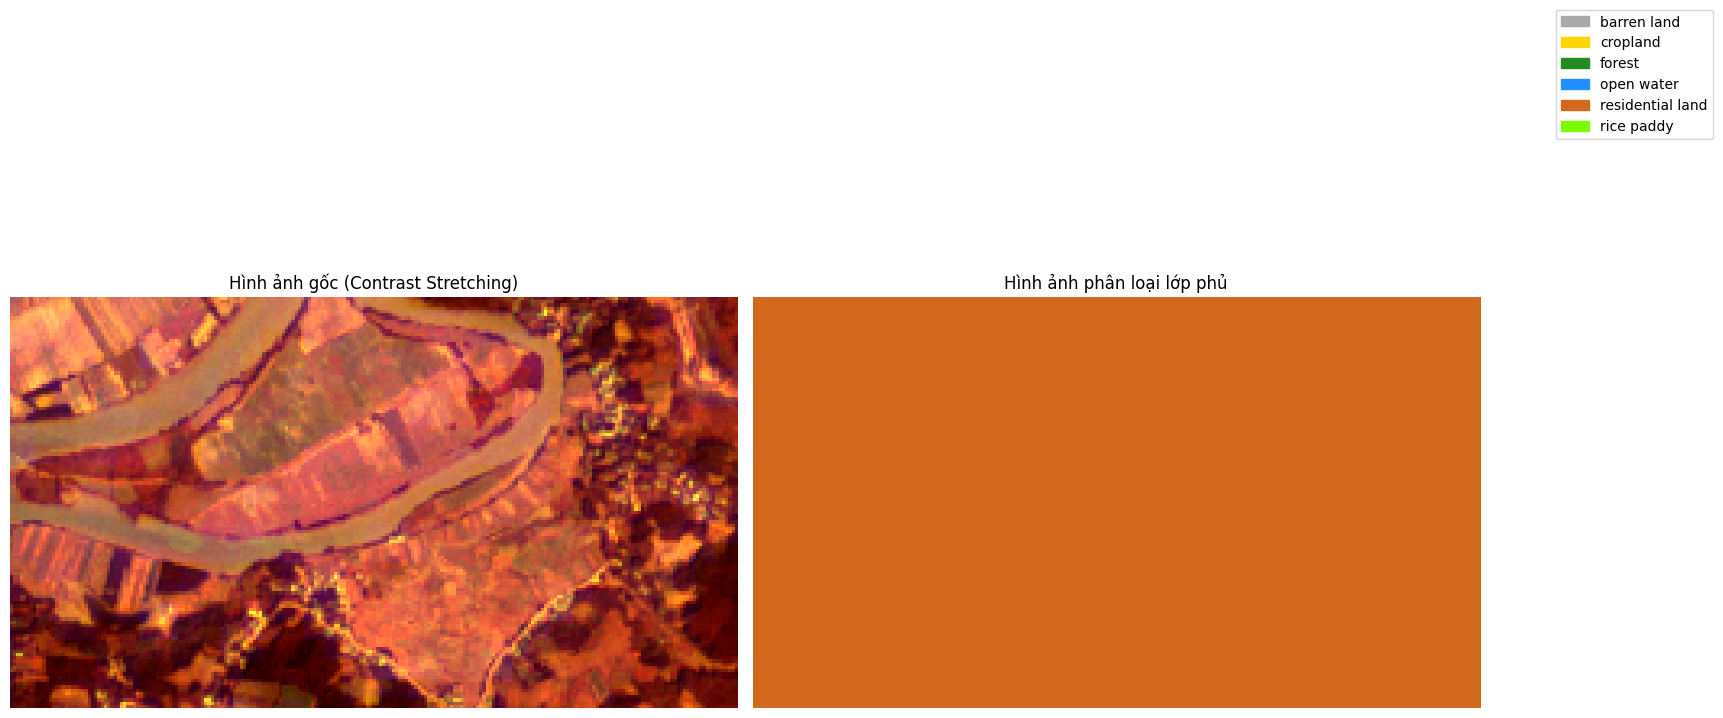

In [38]:
from skimage import exposure # Thêm thư viện skimage
# Tạo bảng màu cho các lớp
PALETTE = ['#A9A9A9',  # barren land - dark gray
           '#FFD700',  # cropland - gold
           '#228B22',  # forest - forest green
           '#1E90FF',  # open water - dodger blue
           '#D2691E',  # residential land - chocolate
           '#7CFC00']  # rice paddy - lawn green

# Colormap và norm cho ảnh phân loại
cmap = ListedColormap(PALETTE)
norm = BoundaryNorm(range(N_CLASSES+1), cmap.N)

# Tạo danh sách tên lớp theo thứ tự
class_names = [None] * N_CLASSES
for label, index in label_mapping.items():
    class_names[index] = label

# Đọc các band RGB (thường là B4, B3, B2)
band_red = image.read(band_indices['B4'])
band_green = image.read(band_indices['B3'])
band_blue = image.read(band_indices['B2'])

# Kết hợp các band lại thành hình ảnh RGB
rgb_image = np.dstack((band_red, band_green, band_blue))

# --- ÁP DỤNG CÁC PHƯƠNG PHÁP LÀM SÁNG ---

p2, p98 = np.percentile(rgb_image, (2, 98))
rgb_image_contrast = exposure.rescale_intensity(rgb_image, in_range=(p2, p98))

# Tạo figure với 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Hiển thị ảnh gốc sau khi áp dụng Contrast Stretching
axes[0].imshow(rgb_image_contrast) # Thay rgb_image bằng rgb_image_contrast
axes[0].set_title("Hình ảnh gốc (Contrast Stretching)") # Thay đổi title cho phù hợp
axes[0].axis('off')

# Hiển thị ảnh phân loại
im = axes[1].imshow(prediction_image, cmap=cmap, norm=norm)
axes[1].set_title("Hình ảnh phân loại lớp phủ")
axes[1].axis('off')

# Tạo chú thích (legend)
patches = [mpatches.Patch(color=PALETTE[i], label=class_names[i]) for i in range(N_CLASSES)]
fig.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()